In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import spectral_density as spec

%load_ext autoreload
%autoreload 2

$\newcommand{\T}{\mathsf{T}}$
$\renewcommand{\vec}{\mathbf}$

# This package

This notebook aims to highlight the basic functionality of the `spectral_density` package. 

## Setup

Let's load a matrix and run the Lanczos algortihm $m$ times. 

Here we use an interval Lanczos code for this, but we note that the design paradigm for `spectral_density` is that computation and approximation should be decoupled. 
In particular, the package focuses on *approximation*, leaving the user free to use any Lanczos code for the *computation*.
Run Lanczos is the only computationally expensive task in the entire pipeline, and we recommend users do this part of the process with a prodection quality Lanczos code suitable for their computationl environment.

Note that, compared to standard KPM implementations, we do not need to specify any hyperparameters at this point! 
We will specify them later, and can even adjust them based on how our approximations are looking. 

In [2]:
# load Hamiltonian
H = sp.io.mmread('./Ga41As41H72.mtx')
H.tocsr()
d = H.shape[0]

In [3]:
# number of LDOS to average
m = 3

# run Lanczos and get recurrence coefficients
αβ_list = []
for _ in range(m):

    # generate random vector
    v = np.random.randn(d)
    v /= np.linalg.norm(v)

    # maximum Lanczos degree
    k = 150

    # run Lanczos and append coefficients
    # we recommend users use production quality Lanczos codes for this step
    αβ_list.append(spec.lanczos(H,v,k,reorth=False))

### SLQ approximation

Computing the SLQ approximation from the Lanczos coefficients is stragithforward.

In [4]:
# define SLQ approximation
ρ_SLQ = spec.SLQ(αβ_list)

The resulting instance of the `SLQ` class is callable, which allows us to easily plot the approximation.

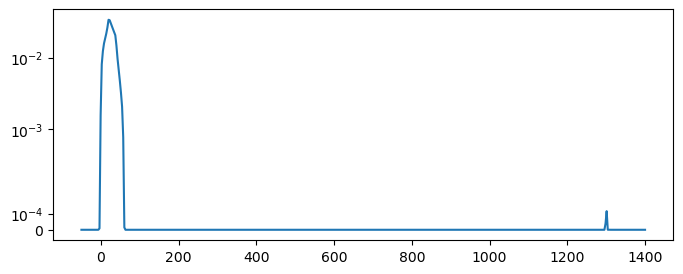

In [5]:
fig,axs = plt.subplots(1,1,figsize=(8,3))

# evaluate SLQ approximation 
x = np.linspace(-50,1400,500)
axs.plot(x,ρ_SLQ(x))

axs.set_yscale('symlog',linthresh=5e-4)

For this particular spectrum, the vast majority of the mass is contained at around 25, but there are a few outlying eigenvalues at 1300.

We can plot both regions separately, using the `width' parameter to control the resolution of the SLQ approximation.
Note that making the width small resolves the Ritz values of the approximation, which often provide good approximations to outlying eigenvalues in the DOS. 
However, in bulk areas of the DOS the Ritz values do not converge, and therefore using too fine of a resolution will result in a poor approximation. 

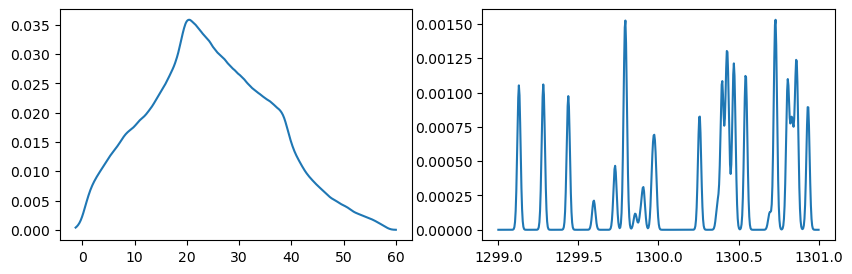

In [6]:
fig,axs = plt.subplots(1,2,figsize=(10,3))

# evaluate SLQ approximation on intervals, with different resolutions
x = np.linspace(-1.3,60,500)
axs[0].plot(x,ρ_SLQ(x,width=.6))

x = np.linspace(1299,1301,500)
axs[1].plot(x,ρ_SLQ(x,width=.01))

We can also estiamte the statistical error due to the randomness in the Lanczos samples using the jackknife method.
**This is not an estimate of the overall error of the algorithm**.
The jackknife error simply estimates the variance of $\rho_{\text{SLQ}}(x)$, which says nothing about how good $\rho_{\text{SLQ}}(x)$ approximates $\rho(x)$.

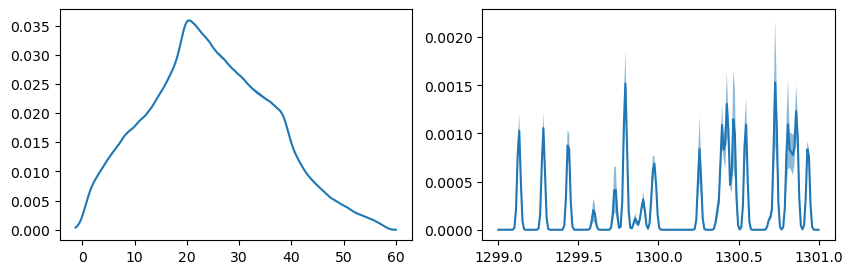

In [7]:
fig,axs = plt.subplots(1,2,figsize=(10,3))

# evaluate SLQ approximation on intervals, with different resolutions
x = np.linspace(-1.3,60,200)
axs[0].plot(x,ρ_SLQ(x,width=.6))
axs[0].fill_between(x,ρ_SLQ(x,width=.6)-ρ_SLQ.var(x,width=.6)**.5,\
                    ρ_SLQ(x,width=.6)+ρ_SLQ.var(x,width=.6)**.5,\
                    alpha=.5)

x = np.linspace(1299,1301,200)
axs[1].plot(x,ρ_SLQ(x,width=.01))
axs[1].fill_between(x,ρ_SLQ(x,width=.01)-ρ_SLQ.var(x,width=.01)**.5,\
                      ρ_SLQ(x,width=.01)+ρ_SLQ.var(x,width=.01)**.5,\
                    alpha=.5)


One possible (although perhaps not failsafe) way of trying to understand the accuracy of the approxiamtion is to look at the SLQ approximations for several consecutive values of the number of support points $k$.
This at least indicates convergence to some distribution, although the use of smoothing will mean that it converges to a smoothed approximation of the DOS.

For example, in the following example, we see that the width parameter is too small for the degree of the approximation used. 

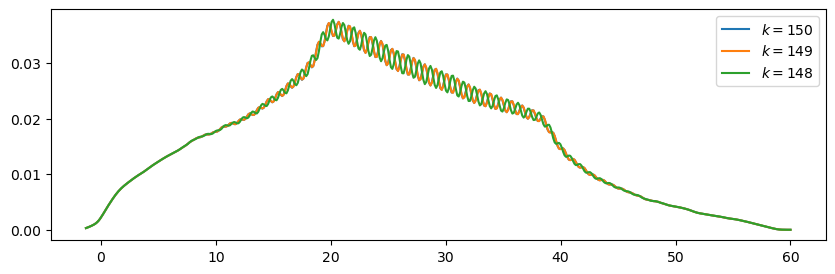

In [8]:
fig,axs = plt.subplots(1,1,figsize=(10,3))

# evaluate SLQ approximation on intervals, with different resolutions
x = np.linspace(-1.3,60,500)
axs.plot(x,ρ_SLQ(x,width=.4),label=f'$k={k}$')
axs.plot(x,ρ_SLQ(x,width=.4,k=k-1),label=f'$k={k-1}$')
axs.plot(x,ρ_SLQ(x,width=.4,k=k-2),label=f'$k={k-2}$')

axs.legend()

Computing spectral sums is also easy.

In [9]:
f = lambda x: np.exp(-x)

# evaluate spectral sum
ρ_SLQ.specsum(f)

(0.007102080511263632, 1.3644604197701376e-08)

## KPM approximation

We will begin with a classic KPM approximation, using the arcsin density shifted and scaled to an interval containg the spectrum of $\vec{H}$. 
Similar to the `SLQ` class, the `KPM` class allows us to easily obtain a KPM approxiamtion.

In [10]:
# define reference density
σ = spec.get_arcsin_density(-2,1302)
ρ_KPM = spec.KPM(αβ_list,σ)

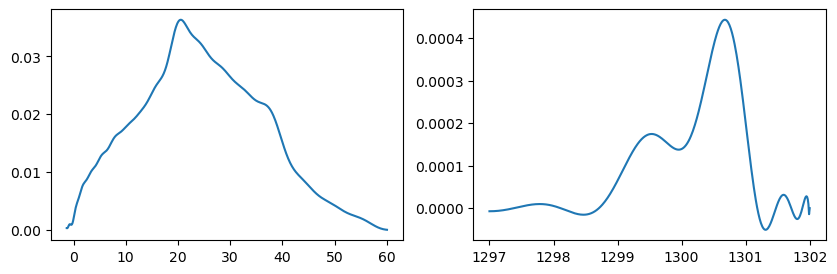

In [11]:
fig,axs = plt.subplots(1,2,figsize=(10,3))

# evaluate KPM approximation on intervals
x = np.linspace(-1.3,60,500)
axs[0].plot(x,ρ_KPM(x))

x = np.linspace(1297,1302,500)
axs[1].plot(x,ρ_KPM(x))

Since the true DOS $\rho(x)$ is zero over a large interval, the KPM approximation exhibits Gibbs oscillations. We could remove these oscillations through the use of a damping scheme, but this also reduces the resoltuion of our approxiamtion even further. 

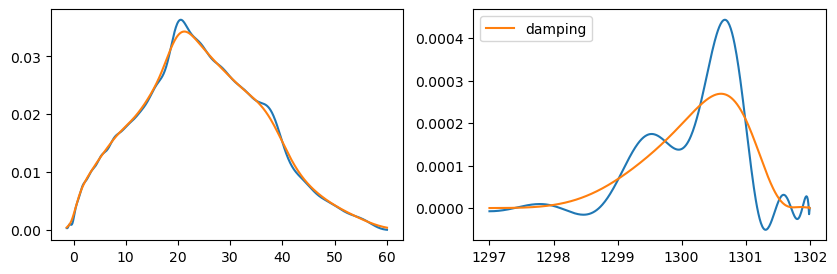

In [12]:
fig,axs = plt.subplots(1,2,figsize=(10,3))

# evaluate KPM approximation on intervals
x = np.linspace(-1.3,60,500)
axs[0].plot(x,ρ_KPM(x))
axs[0].plot(x,ρ_KPM(x,damping='Jackson'))

x = np.linspace(1297,1302,500)
axs[1].plot(x,ρ_KPM(x))
axs[1].plot(x,ρ_KPM(x,damping='Jackson'),label='damping')

axs[1].legend()

Instead, let's define a reference density supported on $[a_L,b_L]\cup[a_R,b_R]$.
We can use the SLQ approximation to estimate reasonable choices for $[a_L,b_L]$ and $[a_R,b_R]$, or we could estimate it by guessing and checking. 
Criticaly, however, we don't need to work with $\vec{H}$ at all!

In [13]:
# define intervals containing spectrum
a_L = np.min(ρ_SLQ.θ)-4e-1
b_L = np.max(ρ_SLQ.θ[ρ_SLQ.θ<200])+4e-1

a_R = np.min(ρ_SLQ.θ[ρ_SLQ.θ>1200])-4e-1
b_R = np.max(ρ_SLQ.θ)+4e-1

We can now define a new density function as a combination of density functions supported on these intervals. The `reference_density` class allows us to combine them intuitively.

In [14]:
# define reference density as sum of densities on the above interavls
σ_L = spec.get_uniform_density(a_L,b_L)
σ_R = spec.get_semicircle_density(a_R,b_R)
σ = .95*σ_L + .05*σ_R

ρ_KPM = spec.KPM(αβ_list,σ)

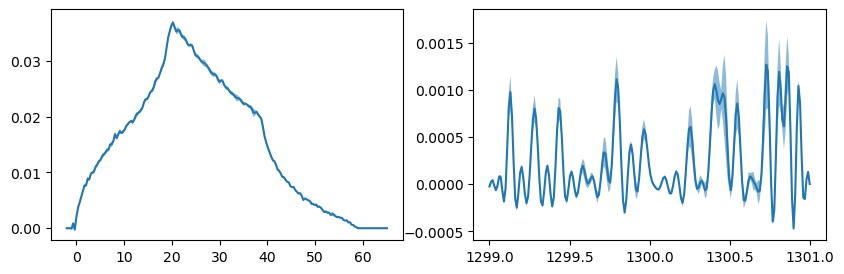

In [15]:
fig,axs = plt.subplots(1,2,figsize=(10,3))

# evaluate KPM approximation 
x = np.linspace(-2,65,200)
axs[0].plot(x,ρ_KPM(x))
axs[0].fill_between(x,ρ_KPM(x)-ρ_KPM.var(x)**.5,\
                    ρ_KPM(x)+ρ_KPM.var(x)**.5,\
                    alpha=.5)

x = np.linspace(1299,1301,200)
axs[1].plot(x,ρ_KPM(x))
axs[1].fill_between(x,ρ_KPM(x)-ρ_KPM.var(x)**.5,\
                    ρ_KPM(x)+ρ_KPM.var(x)**.5,\
                    alpha=.5)

This time the resolution of our approximation is much better.
This is because the KPM doesn't need to try and approximate zero between $b_L$ and $a_R$ since the reference denisty is zero in this region. 
This means the approximation power can be dedicated to the interavls of interest.

As with the SLQ approximation, the stastistical error **is not an estimate of the overall error of the algorithm**. 
It is simply an estaimte of the statistical noise in the approximation due to the randomness in the Lanczos recurrences.

As before, we can check for convergence by producing approximations for varying values of the degree.

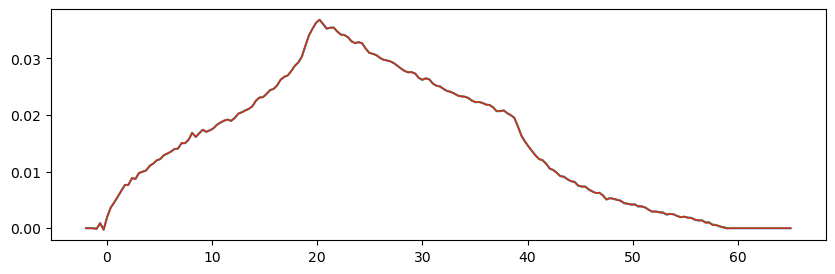

In [16]:
fig,axs = plt.subplots(1,1,figsize=(10,3))

# evaluate KPM approximation 
x = np.linspace(-2,65,200)
axs.plot(x,ρ_KPM(x))
axs.plot(x,ρ_KPM(x,degree=2*k-2),lw=1)
axs.plot(x,ρ_KPM(x,degree=2*k-3),lw=1)
axs.plot(x,ρ_KPM(x,degree=2*k-10),lw=1)



### Other reference densities

Note that we can build our reference density from combinations of Jacobi densities with arbitrary parameters. 
The Jacobi densities on $[-1,1]$ is proprtional to $(1-x)^\alpha(1+x)^\beta$. 
For other reference distributions, you can use the `reference_density` class as long as you know the density function and the orthogonal polynomial recurrence coefficients.

-0.5


(-0.1, 2.0)

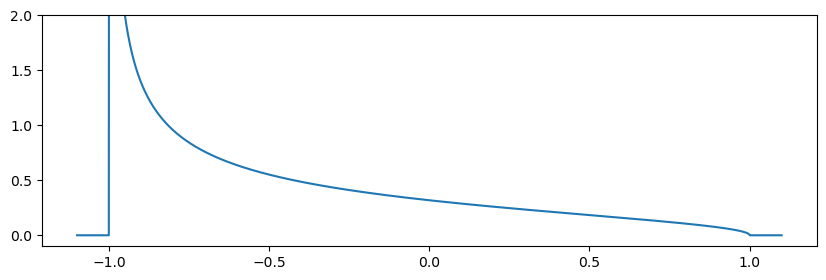

In [17]:
σ = spec.get_jacobi_density(-1,1,.5,-.5)
x = np.linspace(-1.1,1.1,1000)

fig,axs = plt.subplots(1,1,figsize=(10,3))
axs.plot(x,σ(x))
axs.set_ylim(-.1,2)

## Summary

- This package makes it easy to produce spectral density approximations
- For parts of the spectrum where the Ritz values approximate individual eigenvalues, we recommend using the SLQ approximation. 
- For approximating regions of the bulk spectrum, we recommend using KPM with a suitably chosen reference density
